In [18]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import fbeta_score, make_scorer

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (5, 3)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [19]:
def get_cv_metrics(model_name: str, model, X, y):
    
    # custom scorers
    ftwo_scorer = make_scorer(fbeta_score, beta=2, average = 'binary', pos_label = 1)
    fone_0_scorer = make_scorer(fbeta_score, beta=1, average = 'binary', pos_label = 0)
    
    # get cv scores
    precision_1 = cross_val_score(model, X, y, cv=10, scoring='precision').mean()
    recall_1 = cross_val_score(model, X, y, cv=10, scoring='recall').mean()
    ftwo_1 = cross_val_score(model, X, y, cv=10, scoring=ftwo_scorer).mean()
    fone_0 = cross_val_score(model, X, y, cv=10, scoring=fone_0_scorer).mean()
    
    # store in df
    row = pd.DataFrame(data = [[model_name, 
                               precision_1,
                               recall_1,
                               ftwo_1, 
                               fone_0]],
                       columns = results_cols
    )
    
    global cv_metrics
    
    cv_metrics = cv_metrics.append(row)

    return cv_metrics

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Interference', 'Pulsar'],
           yticklabels=['Interference', 'Pulsar']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix')

In [3]:
with open('pickles/df_train.pickle','rb') as read_file:
    df = pickle.load(read_file)
    
with open('pickles/df_test.pickle','rb') as read_file:
    df_test = pickle.load(read_file)

In [4]:
# convert target variable to ordered categorical
df.loc[:, 'candidate_pulsar'] = df['candidate_pulsar'].astype('category')
df['candidate_pulsar'] = df['candidate_pulsar'].cat.as_ordered()

In [5]:
X_train = df[df.columns[:-1]]
y_train = df.candidate_pulsar

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [6]:
results_cols = ['model_id', '1_precision', '1_recall', '1_ftwo_score', '0_f1_score']
cv_metrics = pd.DataFrame(columns = results_cols)

# Model Selection

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

### **Model:** logr_3

---
---

features = itg_mean, itg_kurtosis

---

In [8]:
features3 = ['itg_mean', 'itg_kurtosis']

scaler3 = StandardScaler()
X_train3 = scaler3.fit_transform(df[features3])

In [9]:
logr3 = LogisticRegression(C = 10000)

In [10]:
get_cv_metrics('logr3', logr3, X_train3, y_train)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838


### **Model:** logr_4

---
---

fit on all features

---

In [11]:
scaler4 = StandardScaler()
X_train4 = scaler4.fit_transform(X_train)

logr4 = LogisticRegression(C = 10000)

In [12]:
get_cv_metrics('logr4', logr4, X_train4, y_train)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542


### **Model:** logr_8

---
---

Add polynomial and interaction features to Model 3

---

In [13]:
def feat_eng_8(df):
    df_out = df[['itg_mean', 'itg_kurtosis']].copy()
    df_out['mean_mean'] =         df_out.itg_mean *     df_out.itg_mean
    df_out['kurtosis_mean'] =     df_out.itg_kurtosis * df_out.itg_mean
    df_out['kurtosis_kurtosis'] = df_out.itg_kurtosis * df_out.itg_kurtosis
    df_out['kurtosis_div_mean'] = df_out.itg_kurtosis / df_out.itg_mean
    df_out['mean_div_kurtosis'] = df_out.itg_mean /     df_out.itg_kurtosis
    return df_out

In [14]:
X_train8 = feat_eng_8(X_train)

In [15]:
scaler8 = StandardScaler()
X_train8_sc = scaler8.fit_transform(X_train8)

logr8 = LogisticRegression(C = 10000)

In [16]:
get_cv_metrics('logr8', logr8, X_train8_sc, y_train)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import GridSearchCV
from pprint import pprint

### **Model:** rf2

In [18]:
rf2 = RandomForestClassifier(max_depth = 14, n_estimators = 200)

In [19]:
get_cv_metrics('rf2', rf2, X_train, y_train)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989


### **Model:** rf3

In [20]:
rf3 = RandomForestClassifier(max_depth = 14, n_estimators = 150)

In [21]:
get_cv_metrics('rf3', rf3, X_train, y_train)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142


### **Model:** rf4

In [12]:
# oversample training data

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

X_ovs, y_ovs = RandomOverSampler(random_state = 25).fit_sample(X_train, y_train)

X_smote, y_smote = SMOTE(random_state = 25).fit_sample(X_train, y_train)

X_adasyn, y_adasyn = ADASYN(random_state = 25).fit_sample(X_train, y_train)

In [13]:
rf4 = RandomForestClassifier(max_depth = 15, n_estimators = 200)

In [24]:
get_cv_metrics('rf4_smote', rf4, X_smote, y_smote)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067


In [25]:
get_cv_metrics('logr4_ovs', logr4, scaler4.transform(X_ovs), y_ovs)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024


In [26]:
get_cv_metrics('logr8_ovs', logr8, scaler8.transform(feat_eng_8(X_ovs)), y_ovs)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295


In [27]:
get_cv_metrics('logr4_smote', logr4, scaler4.transform(X_smote), y_smote)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493


In [28]:
get_cv_metrics('logr4_adasyn', logr4, scaler4.transform(X_adasyn), y_adasyn)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_adasyn,0.863423,0.783880,0.798200,0.838149


In [29]:
get_cv_metrics('rf2_smote', rf2, X_smote, y_smote)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_adasyn,0.863423,0.783880,0.798200,0.838149


In [30]:
get_cv_metrics('rf3_smote', rf3, X_smote, y_smote)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_adasyn,0.863423,0.783880,0.798200,0.838149


In [31]:
get_cv_metrics('rf2_adasyn', rf2, X_adasyn, y_adasyn)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_adasyn,0.863423,0.783880,0.798200,0.838149


In [32]:
get_cv_metrics('rf3_adasyn', rf3, X_adasyn, y_adasyn)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,logr3,0.953768,0.795576,0.822795,0.987838
0,logr4,0.942538,0.821530,0.843089,0.988542
0,logr8,0.946955,0.812370,0.836058,0.988321
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_adasyn,0.863423,0.783880,0.798200,0.838149


In [33]:
cv_metrics.sort_values(['1_recall'], ascending = False)

,model_id,1_precision,1_recall,1_ftwo_score,0_f1_score
0,rf4_smote,0.982560,0.965710,0.969625,0.974067
0,rf3_smote,0.981521,0.962327,0.966653,0.972898
0,rf2_smote,0.982049,0.961558,0.966374,0.972342
0,rf3_adasyn,0.958611,0.945031,0.946000,0.951875
0,rf2_adasyn,0.958682,0.942879,0.946667,0.952423
0,logr4_smote,0.972363,0.913661,0.924814,0.945493
0,logr4_ovs,0.972877,0.912047,0.923585,0.945024
0,logr8_ovs,0.963245,0.896132,0.908781,0.933295
0,rf2,0.937644,0.836768,0.855215,0.988989
0,rf3,0.938615,0.832957,0.854534,0.989142


In [14]:
# fit highest recall model to smote training data

rf4.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=15, n_estimators=200)

In [36]:
logr4.fit(scaler4.transform(X_smote), y_smote)

LogisticRegression(C=10000)

# Model Evaluation

In [15]:
with open('pickles/df_test.pickle','rb') as read_file:
    df_test = pickle.load(read_file)
    
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [16]:
test_preds = rf4.predict(X_test)

print(metrics.classification_report(test_preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3222
           1       0.91      0.83      0.87       358

    accuracy                           0.97      3580
   macro avg       0.94      0.91      0.93      3580
weighted avg       0.97      0.97      0.97      3580



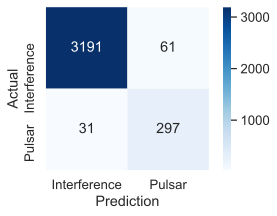

In [21]:
make_confusion_matrix(rf4, threshold=0.5)

In [42]:
test_preds_logr4 = logr4.predict(scaler4.transform(X_test))

print(metrics.classification_report(test_preds_logr4, y_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3186
           1       0.91      0.76      0.83       394

    accuracy                           0.97      3580
   macro avg       0.94      0.88      0.91      3580
weighted avg       0.96      0.97      0.96      3580



In [43]:
rf4.feature_importances_

array([0.14076528, 0.03131313, 0.34478156, 0.20741598, 0.07749591,
       0.1062197 , 0.03477623, 0.0572322 ])